In [ ]:

from statsbombpy import sb 
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import pipeline
import polars as pl
import mplsoccer as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna



import sys
import warnings

sys.path.append("..")
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore")

In [2]:
from utils.passes_handler import PassesHandler
from utils.preprocessing_handler import PreprocessingHandler
from utils.feature_engineering_handler import FeatureEngineeringHandler
from utils.statics import france_argentina_match_id

# Modelling pass difficulties
I believe we can all agree that Pavard's half volley goal was a beautiful, but I the buildup to the goal is also really interesting to look into. Matuidi plays a through ball to Lucas Hernández who then plays a cross at a difficult angle back to Pavard, before he hits a half volley. While the half volley itself requires lots of technique (and luck), I want to answer the following about the passes:
1. Is there a way to quantify the difficulty of the two passes that lead up the goal (i.e. how likely are these types of passes to succeed?)
2. If yes, which pass was more difficult to make (has a lower probability of success)?

Fortunately, there are lots of data related to passes in the ``statsbombpy`` API which we can leverage to adopt a data-driven approach to answer our questions. The plan is to build a model that can tell us give us a pass difficulty score $p_\text{pass}$ for a pass from point $(x_1, y_1)$ to $(x_2, y_2)$ on the pitch. 

# Getting the data


In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values(
    "match_date", ascending=False
)
wc2018_matches = pl.from_pandas(wc2018_matches_df)
match_ids = wc2018_matches.select("match_id").to_series().to_list()

In [4]:
passes_handler = PassesHandler(match_ids=match_ids)
# passes_df = passes_handler.get_passes_from_match_ids()

Now that we have generated a .csv file, let us just simply load that.

In [5]:
passes_df = pl.read_csv("../data/02-analysis/passes.csv")

Let us now split the data into a train set and test set, so we only look at the training data.

In [6]:
train_df = passes_df.filter(pl.col("match_id") != france_argentina_match_id).drop(pl.col("match_id"))
test_df = passes_df.filter(pl.col("match_id") == france_argentina_match_id).drop(pl.col("match_id"))

# Exploring the data
Let us take a quick look at the data and what each feature stands for according to the official [documentation](https://github.com/statsbomb/statsbombpy/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf):

- ``start_x``: x coordinate of the pass origin (where the pass started)
- ``start_y``: y coordinate of the pass origin
- ``end_x``: x coordinate of the pass destination (where the pass ended)
- ``end_y``: y coordinate of the pass destination
- ``length``: length of the pass in yards
- ``height``: the height type of the pass (e.g., Ground Pass, Low Pass, High Pass)
- ``angle``: angle of the pass in radians, with 0 pointing straight ahead. Values between 0 and $\pi$ indicating an angle clockwise.
- ``duration``: the length the event lasted in seconds
- ``body_part``: which body part was used to make the pass (Head, Left foot, Right foot, Other)
- ``under_pressure``: Boolean indicating whether the player making the pass was under pressure by other players. Null if False.
- ``outcome``: result of the pass (e.g., Incomplete, Out, Pass offside, null if completed). This is our target variable.

There is also the ``match_id`` column, but we will not use that as an actual feature in our model. In regards to the coordinate system of the football pitch, the StatsBomb documentation defines the top left corner as the origin $(0,0)$ and the bottom right corner as $(120, 80)$ 

In [7]:
train_df.describe()

statistic,start_x,start_y,end_x,end_y,length,height,angle,duration,body_part,under_pressure,outcome
str,f64,f64,f64,f64,f64,str,f64,f64,str,f64,str
"""count""",61996.0,61996.0,61996.0,61996.0,61996.0,"""61996""",61996.0,61996.0,"""58803""",12894.0,"""12560"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""3193""",49102.0,"""49436"""
"""mean""",60.053229,40.37396,66.731934,40.198722,21.340367,null,0.026687,1.516974,null,1.0,null
"""std""",26.913721,24.038662,26.83367,23.802009,14.889273,null,1.559366,0.87322,null,null,null
"""min""",1.0,1.0,1.0,1.0,0.0,"""Ground Pass""",-3.120319,0.0,"""Drop Kick""",1.0,"""Incomplete"""
"""25%""",40.0,20.0,47.0,20.0,11.18034,null,-1.19029,0.947,null,null,null
"""50%""",59.0,40.0,66.0,40.0,17.464249,null,0.0,1.307,null,null,null
"""75%""",80.0,61.0,87.0,61.0,27.018513,null,1.2490457,1.84,null,null,null
"""max""",120.0,80.0,120.0,80.0,108.66922,"""Low Pass""",3.1415927,8.56,"""Right Foot""",1.0,"""Unknown"""


The ``null_count`` row tells us that the features ``body_part``, ``under_presssure`` and ``outcome`` have null values which will affect our choice of model.

In total, we have 10 features and the target variable. Out of the 10 features, 7 are continious, 2 are categorical and 1 is binary. Let us try to plot the correlation between the continious features.



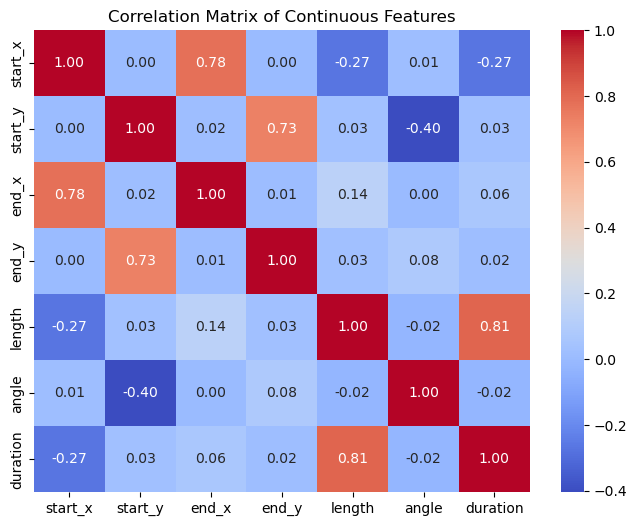

In [8]:
continuous_cols = ["start_x", "start_y", "end_x", "end_y", "length", "angle", "duration"]
corr_matrix = train_df.select(continuous_cols).to_pandas().corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Features")
plt.show()

From the matrix plot, we can observe that ``duration`` and ``length`` are highly positively correlated. There is also a high correlation between ``start_x`` and ``end_x`` and ``start_y`` and ``end_y``. There is also a significant inverse relationship ``start_x`` with ``length`` and ``duration`` and ``start_y`` and ``angle``. If we are considering using linar models, such as logistic regression, it is important to handle the multicollinearity.

Now let us look at the distributions of the data and the null values in the columns ``body_part``, ``under_presssure`` and ``outcome``.

In [9]:
columns = train_df.columns

target_column = "outcome"
categorical_columns = ["height", "body_part", "under_pressure"]
numerical_columns = [col for col in columns if col not in categorical_columns and col != target_column]
print("Number of categorical Columns:", len(categorical_columns))
print("Number of Numerical Columns:", len(numerical_columns))

Number of categorical Columns: 3
Number of Numerical Columns: 7


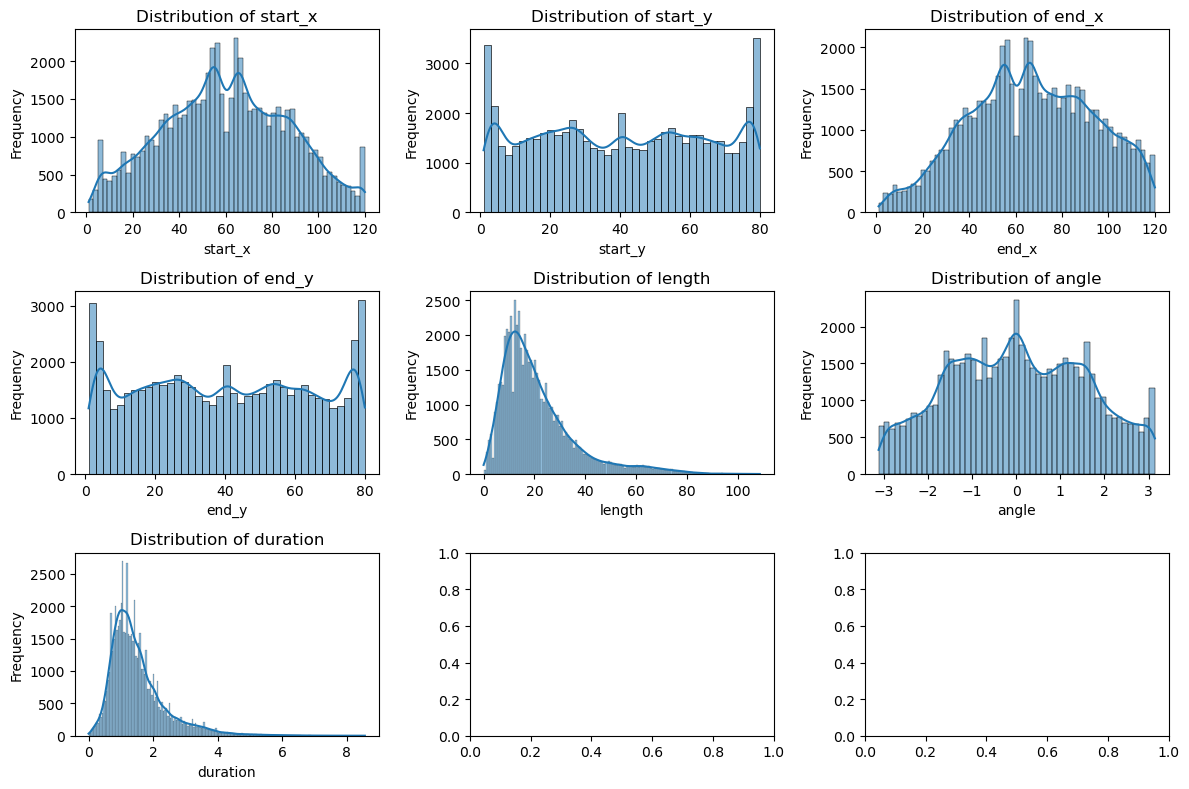

In [10]:
fig, ax = plt.subplots(3, 3 , figsize=(12, 8), tight_layout=True)
ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    sns.histplot(train_df.select(column).to_series(), bins='auto', kde=True, ax=ax[i])
    ax[i].set_title(f"Distribution of {column}")
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Frequency")
plt.show()

We can observe that the distributions for ``length`` and ``duration`` are right-skewed, resembling gamma distributions. The features ``start_x`` and ``end_x`` are approximately Gaussian distributed, while ``start_y``, ``end_y`` seems to follow some bi-modal distribution with high frequencies at the at both extremes near 0 and 80. The distribution for  ``angle``seems to follow a tri-modal distribution with the mode at 0.

Let us now try to visualise the frequencies for the categorical columns. Due to how the data is, we need to perform some simple preprocessing.
- ``body_part``: According to the documentation, the body part is only recorded for "most" passes, which means data is missing at random. We introduce the class "Unknown" for replace null values.
- ``under_pressure``: True equals true, and null equals false. We therefore set null = False
- ``outcome``: According to the documentation, passes missing an outcome are "Completed". We binary encode this variable, as we want to distinguish between "Completed" and "Incompleted".

Note that this preprocessing is tempoary for now, and we will perhaps do something else when training the model.

In [11]:
preprocessing_handler = PreprocessingHandler(df=train_df, categorical_columns=categorical_columns)
train_df = preprocessing_handler.preprocess_categorical_columns()
train_df = preprocessing_handler.preprocess_outcome_column()

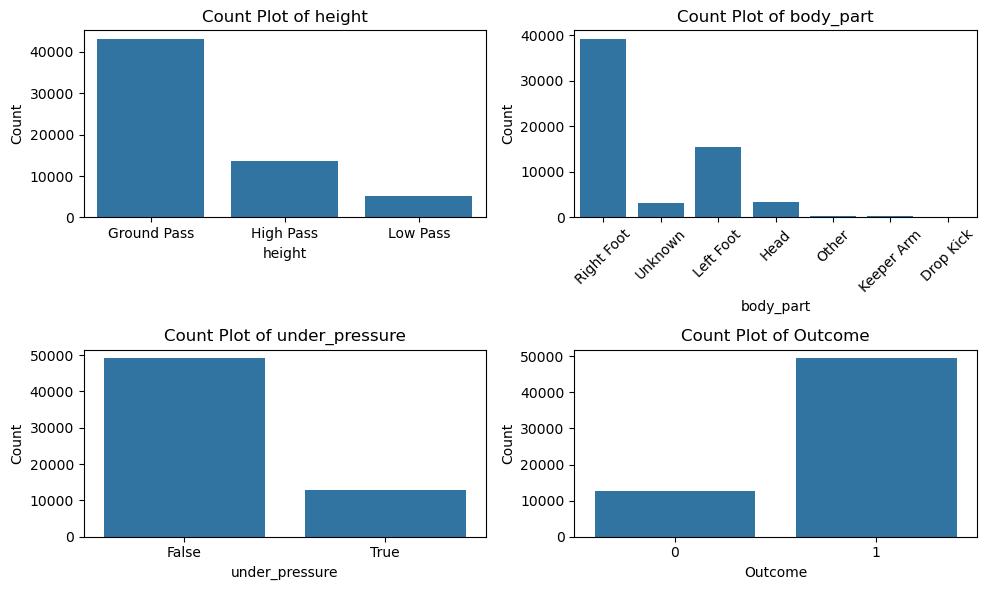

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
ax = ax.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=train_df.select(column).to_series(), ax=ax[i])
    ax[i].set_title(f"Count Plot of {column}")
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Count")
    if column == "body_part":
        ax[i].tick_params(axis='x', rotation=45)

sns.countplot(x=train_df.select("outcome").to_series(), ax=ax[-1])
ax[-1].set_xlabel("Outcome")
ax[-1].set_ylabel("Count")
ax[-1].set_title("Count Plot of Outcome")
plt.show()

Let us look at the percentages for the feature ``under_pressure`` and the target ``outcome``.

In [13]:
train_df.select(pl.col("under_pressure").value_counts(normalize=True), pl.col("outcome").value_counts(normalize=True))

under_pressure,outcome
struct[2],struct[2]
"{false,0.792019}","{1,0.797406}"
"{true,0.207981}","{0,0.202594}"


We observe that a large majority of passes were completed: Around 80% are completed with only 20% incompleted. Curiously, around 21% of the passes were made under pressure and 79% were not made under pressure. This is a pretty severe class imbalance for the target variable ``outcome`` which we will need to handle when splitting the dataset and perform tratified K-fold on the target variable ``outcome`` to ensure each fold contains the same proportions of completed and incompleted passes.

Another thing I like to do is to plot the mutual information to measure how each base feature reduces uncertainty about the target variable ``outcome`` before the feature engineering phase.

In [14]:
y_train = train_df.select("outcome").to_series()
X_train = train_df.drop(pl.col("outcome"))


In [21]:
feature_engineering_handler = FeatureEngineeringHandler(train_df=X_train)
X_train = feature_engineering_handler.encode_columns(columns=["height", "body_part"])


In [22]:
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

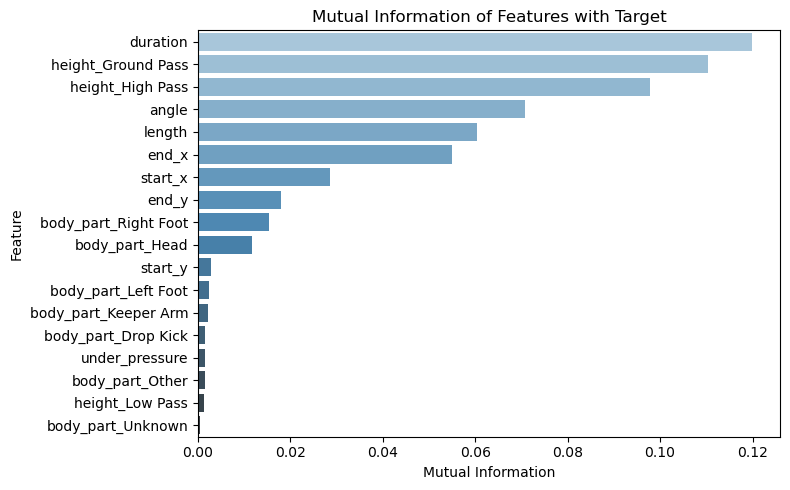

In [28]:
import pandas as pd

# Create a DataFrame and sort
mi_df = pl.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi})
mi_df = mi_df.sort(by='Mutual Information', descending=True)

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Mutual Information',
    y='Feature',
    data=mi_df,
    palette='Blues_d'
)
plt.title('Mutual Information of Features with Target')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Ok, interesting. It seems the most important features contributing to the pass ``outcome`` is ``duration``, ``height``, ``angle`` and ``length``.  Among the coordinate features, ``end_x``, ``start_x``. ``end_y`` contribute much more to the mutual information than ``start_y``. In general the feature ``under_pressure`` and all ``body_part`` features contribute very little to the mutual information. 

Now we have a better idea on which features to focus on in the feature engineering phase.

# Feature engineering
Let us continue with some feature engineering phase where our goal is to make the data more "understandable" for our machine learning model. For our model, we will start by using a XGBClassifier model from XGBoost, since it offers a lot of neat advantages:
- General good performance on tabular machine learning problems with fast train/inference.
- Tree-based model, meaning it handles null values and features of different scales